## **Installation**

In [4]:
!pip -q install umap-learn xgboost


## 2.**Imports** **bold text**

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
%matplotlib inline


## **3.Load Dataset**

In [6]:
path = "/content/diabetes.csv"
df = pd.read_csv(path)

print("Shape:", df.shape)
display(df.head())
print("\nOutcome distribution:\n", df["Outcome"].value_counts())


Shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1



Outcome distribution:
 Outcome
0    500
1    268
Name: count, dtype: int64


## 4.**Split X/y + Fix “0 means missing” + Train/Test split**

In [7]:
X = df.drop(columns=["Outcome"]).copy()
y = df["Outcome"].astype(int).copy()

# In Pima diabetes dataset, these 0 values often mean missing
zero_as_missing = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in zero_as_missing:
    if col in X.columns:
        X[col] = X[col].replace(0, np.nan)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train_raw.shape, "Test shape:", X_test_raw.shape)


Train shape: (614, 8) Test shape: (154, 8)


## **5.Impute + Scale (VERY important for clustering)**





In [8]:
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train_raw)
X_test_imp  = imputer.transform(X_test_raw)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled  = scaler.transform(X_test_imp)

feature_names = X.columns.tolist()
print("✅ Preprocessing done.")


✅ Preprocessing done.


## **6.DR + Plot helper functions**

In [9]:
def get_dr_embeddings(X_scaled, method="pca", random_state=42):
    if method == "none":
        return X_scaled
    if method == "pca":
        return PCA(n_components=2, random_state=random_state).fit_transform(X_scaled)
    if method == "tsne":
        return TSNE(
            n_components=2, perplexity=30, learning_rate="auto",
            init="pca", random_state=random_state
        ).fit_transform(X_scaled)
    if method == "umap":
        return umap.UMAP(n_components=2, random_state=random_state).fit_transform(X_scaled)
    raise ValueError("Unknown DR method")

def plot_2d(X_2d, labels, title):
    plt.figure(figsize=(7,6))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=25)
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.colorbar(label="Cluster ID")
    plt.tight_layout()
    plt.show()


## **7.Clustering + scoring helper functions**

In [10]:
def safe_cluster_scores(X_emb, labels):
    uniq = set(labels)
    if len(uniq) <= 1:
        return None

    # If DBSCAN has noise (-1), evaluate only non-noise points (if enough)
    if -1 in uniq:
        mask = labels != -1
        if mask.sum() < 10:
            return None
        X_nn = X_emb[mask]
        y_nn = labels[mask]
        if len(set(y_nn)) <= 1:
            return None
        sil = silhouette_score(X_nn, y_nn)
        dbi = davies_bouldin_score(X_nn, y_nn)
        chi = calinski_harabasz_score(X_nn, y_nn)
        return sil, dbi, chi

    sil = silhouette_score(X_emb, labels)
    dbi = davies_bouldin_score(X_emb, labels)
    chi = calinski_harabasz_score(X_emb, labels)
    return sil, dbi, chi

def run_clustering(X_emb, algo, k=3, eps=0.8, min_samples=5, random_state=42):
    if algo == "kmeans":
        return KMeans(n_clusters=k, random_state=random_state, n_init="auto").fit_predict(X_emb)
    if algo == "hierarchical":
        return AgglomerativeClustering(n_clusters=k).fit_predict(X_emb)
    if algo == "dbscan":
        return DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X_emb)
    raise ValueError("Unknown clustering algorithm")


## **8.Benchmark ALL combinations (DR × clustering)**

In [11]:
dr_methods = ["none", "pca", "tsne", "umap"]
cluster_algos = ["kmeans", "hierarchical", "dbscan"]

rows = []
for dr in dr_methods:
    X_emb = get_dr_embeddings(X_train_scaled, method=dr, random_state=42)

    for algo in cluster_algos:
        if algo in ["kmeans", "hierarchical"]:
            for k in [2, 3, 4, 5]:
                labels = run_clustering(X_emb, algo=algo, k=k, random_state=42)
                scores = safe_cluster_scores(X_emb, labels)
                if scores is None:
                    continue
                sil, dbi, chi = scores
                rows.append([dr, algo, f"k={k}", sil, dbi, chi, len(set(labels))])

        if algo == "dbscan":
            for eps in [0.3, 0.5, 0.7, 0.9, 1.1]:
                labels = run_clustering(X_emb, algo=algo, eps=eps, min_samples=5, random_state=42)
                scores = safe_cluster_scores(X_emb, labels)
                if scores is None:
                    continue
                sil, dbi, chi = scores
                rows.append([dr, algo, f"eps={eps}", sil, dbi, chi, len(set(labels))])

bench = pd.DataFrame(rows, columns=[
    "DR", "Clustering", "Params", "Silhouette(↑)", "DBI(↓)", "CH(↑)", "NumClusters"
]).sort_values("Silhouette(↑)", ascending=False).reset_index(drop=True)

print("✅ Benchmark completed. Top 10 results:")
display(bench.head(10))


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ Benchmark completed. Top 10 results:


,DR,Clustering,Params,Silhouette(↑),DBI(↓),CH(↑),NumClusters
0,tsne,kmeans,k=2,0.483703,0.767955,902.696228,2
1,umap,kmeans,k=2,0.449493,0.871023,704.829956,2
2,umap,kmeans,k=5,0.439426,0.711720,805.197632,5
3,tsne,hierarchical,k=2,0.412630,0.730564,573.476135,2
4,umap,kmeans,k=4,0.406190,0.848151,650.104370,4
5,tsne,kmeans,k=5,0.404789,0.806737,815.337769,5
6,pca,kmeans,k=3,0.403725,0.868034,460.651163,3
7,umap,hierarchical,k=5,0.403558,0.747816,707.067200,5
8,tsne,kmeans,k=3,0.398594,0.897574,793.368164,3
9,umap,hierarchical,k=2,0.380615,0.809298,443.767090,2


## **9.Show TOP 5 best combinations + plot each cluster diagram**

===== TOP 5 BEST COMBINATIONS =====


,DR,Clustering,Params,Silhouette(↑),DBI(↓),CH(↑),NumClusters
0,tsne,kmeans,k=2,0.483703,0.767955,902.696228,2
1,umap,kmeans,k=2,0.449493,0.871023,704.829956,2
2,umap,kmeans,k=5,0.439426,0.711720,805.197632,5
3,tsne,hierarchical,k=2,0.412630,0.730564,573.476135,2
4,umap,kmeans,k=4,0.406190,0.848151,650.104370,4


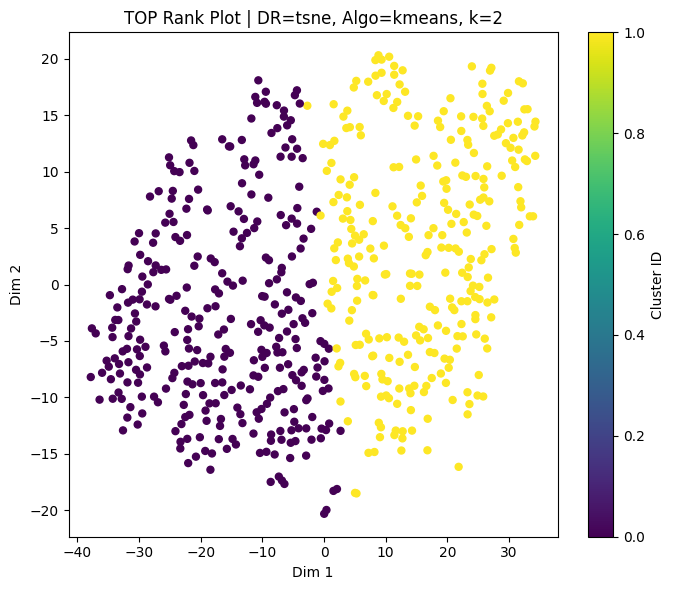

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


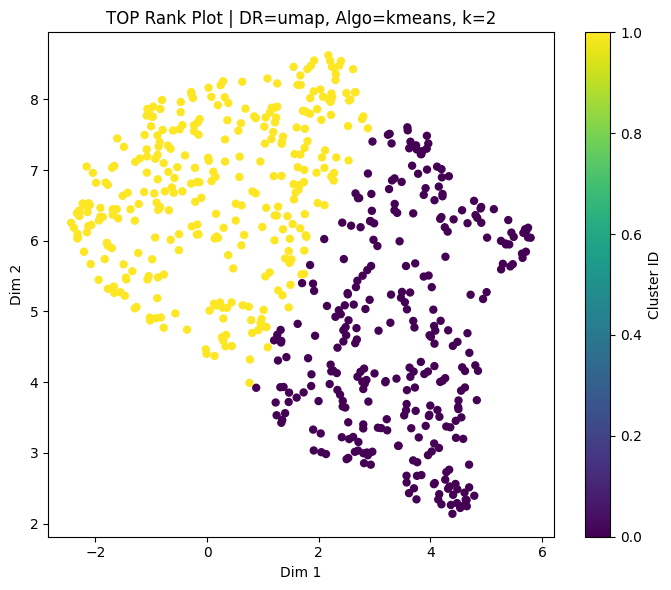

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


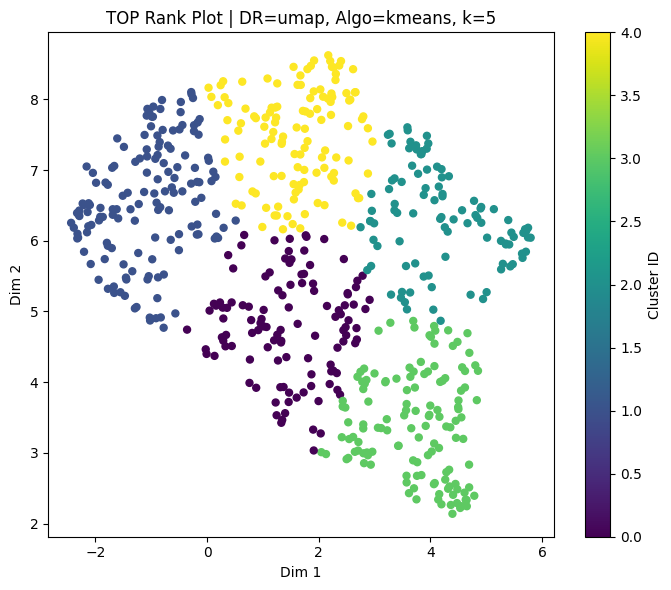

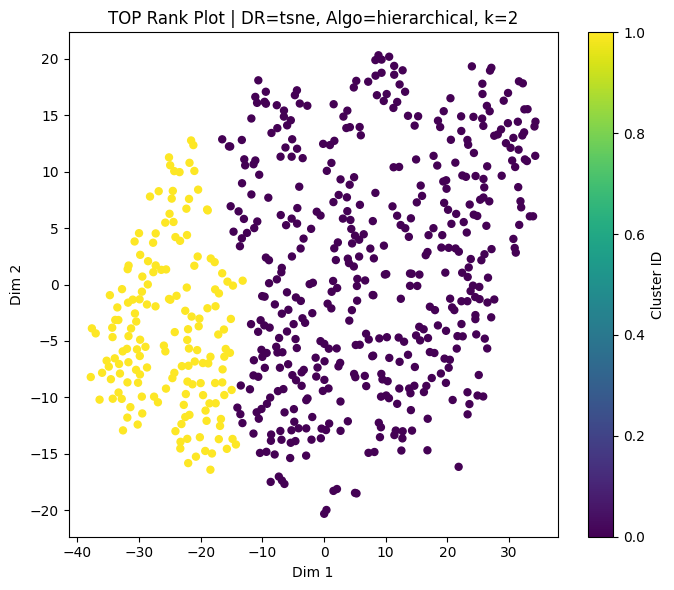

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


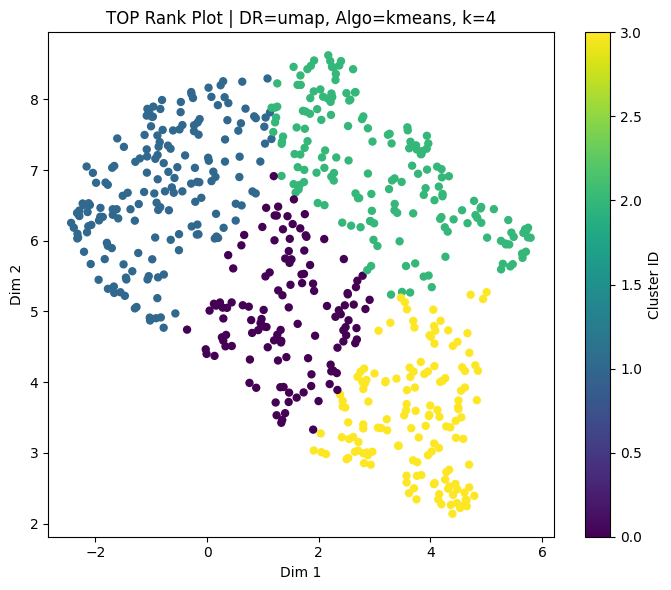

In [12]:
topN = 5
top = bench.head(topN).copy()
print("===== TOP 5 BEST COMBINATIONS =====")
display(top)

for rank, row in top.iterrows():
    dr = row["DR"]
    algo = row["Clustering"]
    params = row["Params"]

    k_tmp, eps_tmp = 3, 0.8
    if str(params).startswith("k="):
        k_tmp = int(str(params).split("=")[1])
    if str(params).startswith("eps="):
        eps_tmp = float(str(params).split("=")[1])

    X_tmp = get_dr_embeddings(X_train_scaled, method=dr, random_state=42)
    labels_tmp = run_clustering(X_tmp, algo=algo, k=k_tmp, eps=eps_tmp, random_state=42)

    # plot only if 2D
    if dr != "none":
        plot_2d(X_tmp, labels_tmp, f"TOP Rank Plot | DR={dr}, Algo={algo}, {params}")
    else:
        print(f"DR=none for rank plot (no 2D view). DR={dr}, Algo={algo}, {params}")


## **10.Picking BEST setup + ploting it**

✅ BEST CONFIG:
DR                     tsne
Clustering           kmeans
Params                  k=2
Silhouette(↑)      0.483703
DBI(↓)             0.767955
CH(↑)            902.696228
NumClusters               2
Name: 0, dtype: object


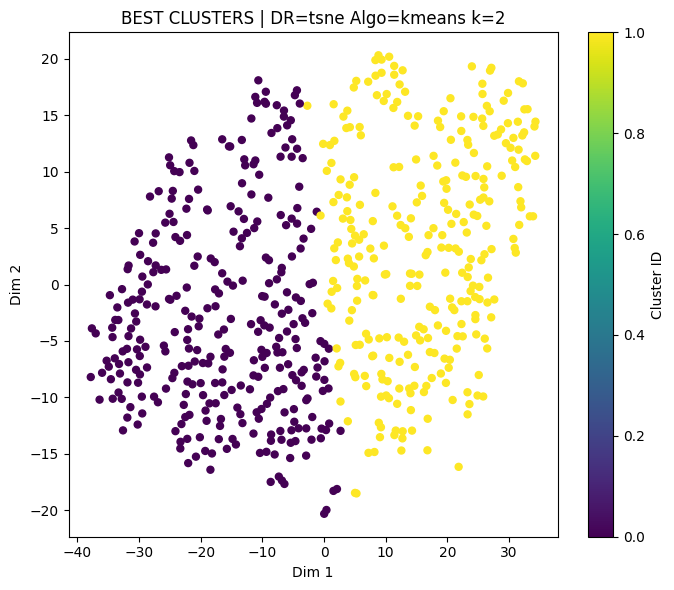

In [13]:
best = bench.iloc[0]
best_dr = best["DR"]
best_algo = best["Clustering"]
best_params = best["Params"]

k_best, eps_best = 3, 0.8
if str(best_params).startswith("k="):
    k_best = int(str(best_params).split("=")[1])
if str(best_params).startswith("eps="):
    eps_best = float(str(best_params).split("=")[1])

print("✅ BEST CONFIG:")
print(best)

X_best_2d = get_dr_embeddings(X_train_scaled, method=best_dr, random_state=42)
labels_best = run_clustering(X_best_2d, algo=best_algo, k=k_best, eps=eps_best, random_state=42)

if best_dr != "none":
    plot_2d(X_best_2d, labels_best, f"BEST CLUSTERS | DR={best_dr} Algo={best_algo} {best_params}")
else:
    print("Best DR=none → choose PCA/UMAP row for visualization if needed.")


## **11.Convert cluster colors into “Low/Medium/High risk**

In [14]:
# Build a train dataframe in ORIGINAL feature scale (imputed, not scaled) for interpretation
train_df = pd.DataFrame(X_train_imp, columns=feature_names)
train_df["cluster_id"] = labels_best
train_df["Outcome"] = y_train.reset_index(drop=True).values

# Summary table per cluster
summary = train_df.groupby("cluster_id").agg(
    n=("Outcome", "count"),
    outcome_rate=("Outcome", "mean"),   # not used for clustering, only interpretation
    mean_glucose=("Glucose", "mean"),
    mean_bmi=("BMI", "mean"),
    mean_age=("Age", "mean"),
    mean_bp=("BloodPressure", "mean"),
    mean_insulin=("Insulin", "mean"),
).reset_index()

# Risk score based only on features (no Outcome)
summary["risk_score"] = (
    summary["mean_glucose"].rank(pct=True) +
    summary["mean_bmi"].rank(pct=True) +
    summary["mean_age"].rank(pct=True)
)

summary = summary.sort_values("risk_score").reset_index(drop=True)

# Make risk labels based on number of clusters
if len(summary) == 3:
    risk_labels = ["Low-risk", "Medium-risk", "High-risk"]
elif len(summary) == 2:
    risk_labels = ["Low-risk", "High-risk"]
else:
    risk_labels = ["Single-group"] * len(summary)

summary["risk_label"] = risk_labels[:len(summary)]

print("===== CLUSTER INTERPRETATION TABLE =====")
display(summary)

cluster_to_risk = dict(zip(summary["cluster_id"], summary["risk_label"]))
print("Cluster → Risk mapping:", cluster_to_risk)


===== CLUSTER INTERPRETATION TABLE =====


,cluster_id,n,outcome_rate,mean_glucose,mean_bmi,mean_age,mean_bp,mean_insulin,risk_score,risk_label
0,0,322,0.195652,112.267081,30.104348,26.07764,66.776398,115.236025,1.5,Low-risk
1,1,292,0.517123,132.041096,35.032877,41.40411,78.054795,162.482877,3.0,High-risk


Cluster → Risk mapping: {0: 'Low-risk', 1: 'High-risk'}


/content/diabetes.csv

## **12.Plot BEST clusters again + write “Low/Medium/High**





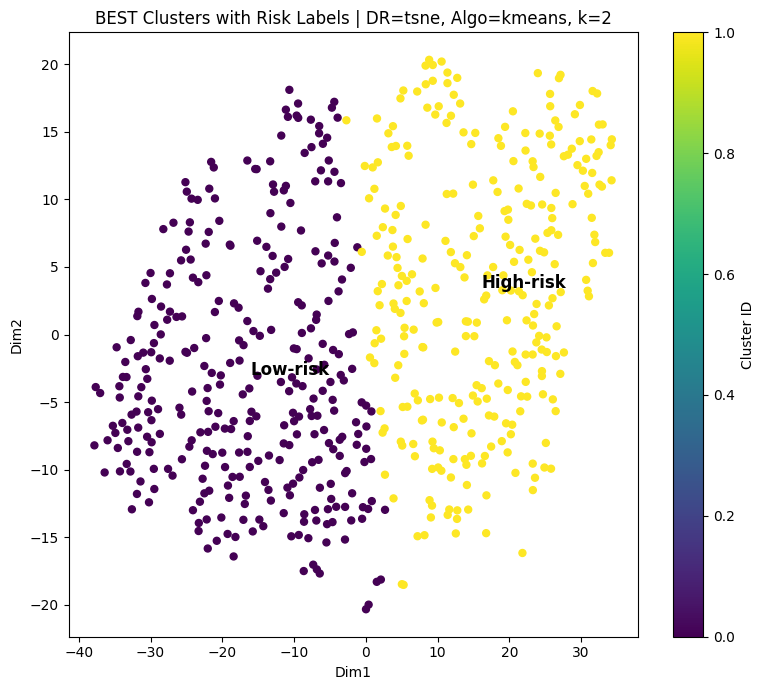

In [15]:
import numpy as np

if best_dr != "none":
    plt.figure(figsize=(8,7))
    plt.scatter(X_best_2d[:,0], X_best_2d[:,1], c=labels_best, s=25)
    plt.title(f"BEST Clusters with Risk Labels | DR={best_dr}, Algo={best_algo}, {best_params}")
    plt.xlabel("Dim1"); plt.ylabel("Dim2")
    plt.colorbar(label="Cluster ID")

    for cid in np.unique(labels_best):
        pts = X_best_2d[labels_best == cid]
        cx, cy = pts.mean(axis=0)
        plt.text(cx, cy, cluster_to_risk.get(cid, f"Cluster {cid}"),
                 fontsize=12, weight="bold")
    plt.tight_layout()
    plt.show()
else:
    print("Best DR=none so cannot label clusters on a 2D map. Use PCA/UMAP for plotting.")


## **13.Extra plots**

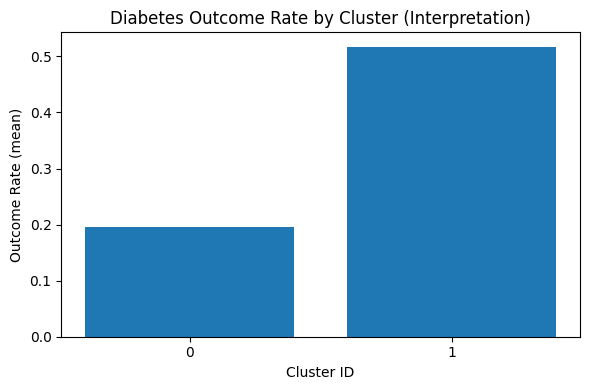

/tmp/ipython-input-1421378441.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(cid) for cid in sorted(train_df["cluster_id"].unique())])


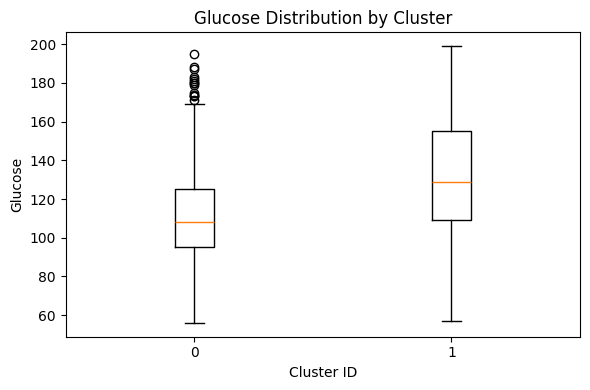

/tmp/ipython-input-1421378441.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(cid) for cid in sorted(train_df["cluster_id"].unique())])


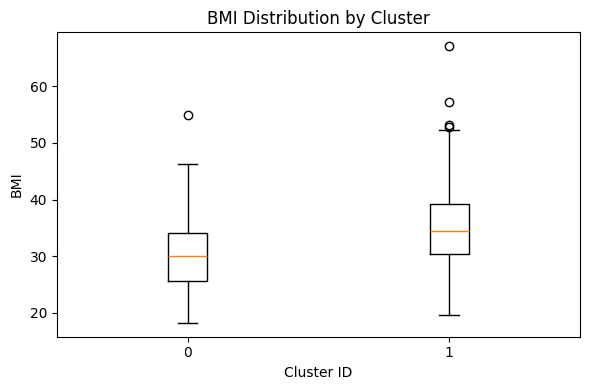

/tmp/ipython-input-1421378441.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(cid) for cid in sorted(train_df["cluster_id"].unique())])


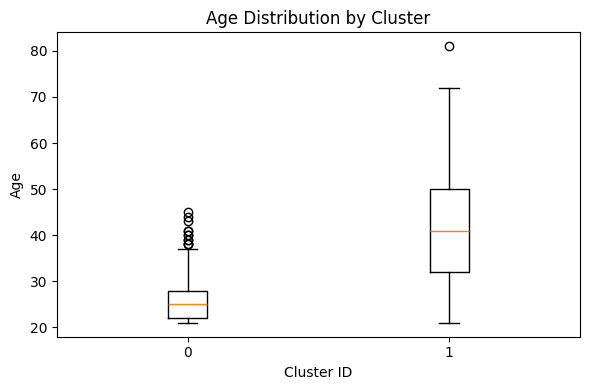

In [16]:
# Outcome rate bar chart by cluster
plt.figure(figsize=(6,4))
plt.bar(summary["cluster_id"].astype(str), summary["outcome_rate"])
plt.title("Diabetes Outcome Rate by Cluster (Interpretation)")
plt.xlabel("Cluster ID")
plt.ylabel("Outcome Rate (mean)")
plt.tight_layout()
plt.show()

# Boxplots: show how risk features differ by cluster
features_to_show = ["Glucose", "BMI", "Age"]
for f in features_to_show:
    plt.figure(figsize=(6,4))
    data = [train_df[train_df["cluster_id"]==cid][f].values for cid in sorted(train_df["cluster_id"].unique())]
    plt.boxplot(data, labels=[str(cid) for cid in sorted(train_df["cluster_id"].unique())])
    plt.title(f"{f} Distribution by Cluster")
    plt.xlabel("Cluster ID")
    plt.ylabel(f)
    plt.tight_layout()
    plt.show()


## **14.Cluster-as-feature (KMeans) + Classification (NoCluster vs WithCluster)**

In [17]:
# Choose K for cluster feature
# If best algo used k, reuse it. Otherwise choose 3.
cluster_k = k_best if best_algo in ["kmeans", "hierarchical"] else 3

# Fit KMeans on scaled train to create cluster feature
kmeans_feat = KMeans(n_clusters=cluster_k, random_state=42, n_init="auto")
train_cluster_feat = kmeans_feat.fit_predict(X_train_scaled)
test_cluster_feat  = kmeans_feat.predict(X_test_scaled)

X_train_plus = np.column_stack([X_train_scaled, train_cluster_feat])
X_test_plus  = np.column_stack([X_test_scaled,  test_cluster_feat])

models = [
    ("LogReg", LogisticRegression(max_iter=3000)),
    ("RandomForest", RandomForestClassifier(n_estimators=400, random_state=42)),
    ("XGBoost", XGBClassifier(
        n_estimators=500, learning_rate=0.05, max_depth=4,
        subsample=0.9, colsample_bytree=0.9,
        random_state=42, eval_metric="logloss"
    ))
]

def eval_models(Xtr, Xte, ytr, yte, title):
    print("\n====", title, "====")
    rows = []
    for name, model in models:
        model.fit(Xtr, ytr)
        pred = model.predict(Xte)
        acc = accuracy_score(yte, pred)
        f1 = f1_score(yte, pred)
        rows.append([name, acc, f1])
        print(f"{name}: Accuracy={acc:.4f}, F1={f1:.4f}")
    return pd.DataFrame(rows, columns=["Model","Accuracy","F1"])

base = eval_models(X_train_scaled, X_test_scaled, y_train, y_test, "WITHOUT cluster feature")
plus = eval_models(X_train_plus,  X_test_plus,  y_train, y_test, "WITH cluster feature")

final = base.merge(plus, on="Model", suffixes=("_NoCluster", "_WithCluster"))
final["Acc_Improve"] = final["Accuracy_WithCluster"] - final["Accuracy_NoCluster"]
final["F1_Improve"]  = final["F1_WithCluster"] - final["F1_NoCluster"]

print("\n===== FINAL COMPARISON TABLE  =====")
display(final.sort_values("Acc_Improve", ascending=False))



==== WITHOUT cluster feature ====
LogReg: Accuracy=0.7078, F1=0.5455
RandomForest: Accuracy=0.7403, F1=0.5918
XGBoost: Accuracy=0.7468, F1=0.6355

==== WITH cluster feature ====
LogReg: Accuracy=0.6948, F1=0.5347
RandomForest: Accuracy=0.7403, F1=0.6078
XGBoost: Accuracy=0.7468, F1=0.6286

===== FINAL COMPARISON TABLE  =====


,Model,Accuracy_NoCluster,F1_NoCluster,Accuracy_WithCluster,F1_WithCluster,Acc_Improve,F1_Improve
1,RandomForest,0.740260,0.591837,0.740260,0.607843,0.000000,0.016006
2,XGBoost,0.746753,0.635514,0.746753,0.628571,0.000000,-0.006943
0,LogReg,0.707792,0.545455,0.694805,0.534653,-0.012987,-0.010801


## **15.5-Fold Cross Validation (more valid for report)**

In [18]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_score(model, X, y):
    acc = cross_val_score(model, X, y, cv=cv, scoring="accuracy").mean()
    f1  = cross_val_score(model, X, y, cv=cv, scoring="f1").mean()
    return acc, f1

rows = []
for name, model in models:
    acc, f1 = cv_score(model, X_train_scaled, y_train)
    rows.append([name, "NoCluster", acc, f1])

for name, model in models:
    acc, f1 = cv_score(model, X_train_plus, y_train)
    rows.append([name, "WithCluster", acc, f1])

cv_df = pd.DataFrame(rows, columns=["Model","Setting","CV_Accuracy","CV_F1"])
print("===== 5-FOLD CV RESULTS =====")
display(cv_df)


===== 5-FOLD CV RESULTS =====


,Model,Setting,CV_Accuracy,CV_F1
0,LogReg,NoCluster,0.786605,0.651082
1,RandomForest,NoCluster,0.770345,0.645630
2,XGBoost,NoCluster,0.739411,0.605924
3,LogReg,WithCluster,0.791497,0.665266
4,RandomForest,WithCluster,0.768719,0.639733
5,XGBoost,WithCluster,0.745915,0.619589


## **Confusion Matrix**

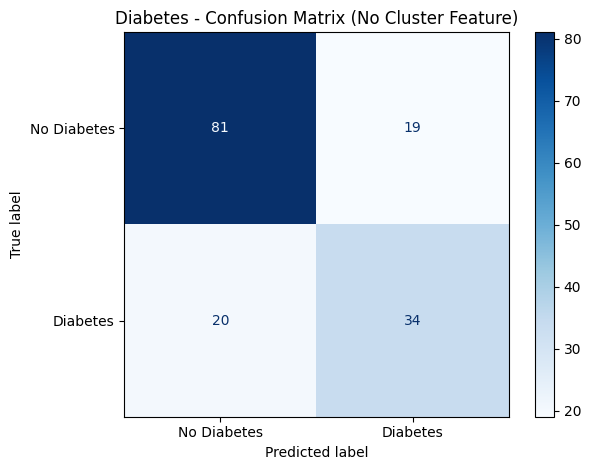

=== Diabetes Report (No Cluster) ===
              precision    recall  f1-score   support

 No Diabetes       0.80      0.81      0.81       100
    Diabetes       0.64      0.63      0.64        54

    accuracy                           0.75       154
   macro avg       0.72      0.72      0.72       154
weighted avg       0.75      0.75      0.75       154



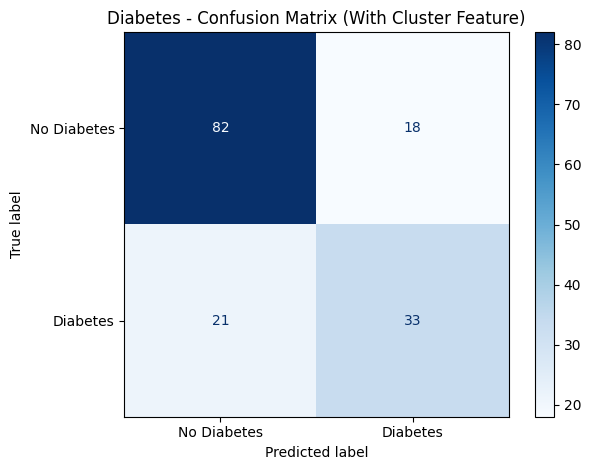

=== Diabetes Report (With Cluster) ===
              precision    recall  f1-score   support

 No Diabetes       0.80      0.82      0.81       100
    Diabetes       0.65      0.61      0.63        54

    accuracy                           0.75       154
   macro avg       0.72      0.72      0.72       154
weighted avg       0.74      0.75      0.75       154



In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

def plot_cm(y_true, y_pred, title, labels=("No Diabetes", "Diabetes")):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=list(labels))
    disp.plot(cmap="Blues")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ---- Case A: WITHOUT cluster feature ----
model_no = XGBClassifier(
    n_estimators=500, learning_rate=0.05, max_depth=4,
    subsample=0.9, colsample_bytree=0.9,
    random_state=42, eval_metric="logloss"
)
model_no.fit(X_train_scaled, y_train)
pred_no = model_no.predict(X_test_scaled)

plot_cm(y_test, pred_no, "Diabetes - Confusion Matrix (No Cluster Feature)")
print("=== Diabetes Report (No Cluster) ===")
print(classification_report(y_test, pred_no, target_names=["No Diabetes", "Diabetes"]))

# ---- Case B: WITH cluster feature ----
model_yes = XGBClassifier(
    n_estimators=500, learning_rate=0.05, max_depth=4,
    subsample=0.9, colsample_bytree=0.9,
    random_state=42, eval_metric="logloss"
)
model_yes.fit(X_train_plus, y_train)
pred_yes = model_yes.predict(X_test_plus)

plot_cm(y_test, pred_yes, "Diabetes - Confusion Matrix (With Cluster Feature)")
print("=== Diabetes Report (With Cluster) ===")
print(classification_report(y_test, pred_yes, target_names=["No Diabetes", "Diabetes"]))


## **Precision/Recall/F1 score**

===== DIABETES MODEL EVALUATION =====

DIABETES - WITHOUT CLUSTER
Precision: 0.6415094339622641
Recall   : 0.6296296296296297
F1-score : 0.6355140186915887

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.80      0.81      0.81       100
    Diabetes       0.64      0.63      0.64        54

    accuracy                           0.75       154
   macro avg       0.72      0.72      0.72       154
weighted avg       0.75      0.75      0.75       154



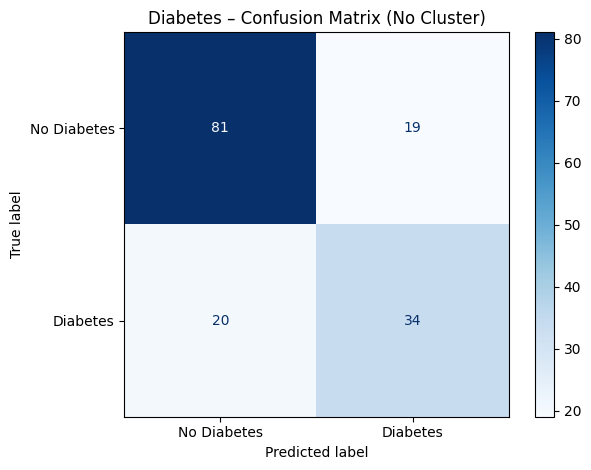


DIABETES - WITH CLUSTER
Precision: 0.6470588235294118
Recall   : 0.6111111111111112
F1-score : 0.6285714285714286

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.80      0.82      0.81       100
    Diabetes       0.65      0.61      0.63        54

    accuracy                           0.75       154
   macro avg       0.72      0.72      0.72       154
weighted avg       0.74      0.75      0.75       154



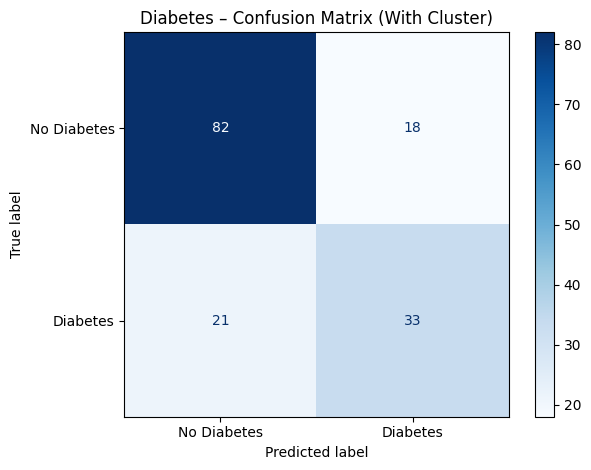

In [20]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score, classification_report
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

print("===== DIABETES MODEL EVALUATION =====")

# -------------------------------
# CASE 1: WITHOUT CLUSTER FEATURE
# -------------------------------
model_no = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    eval_metric="logloss"
)

model_no.fit(X_train_scaled, y_train)
pred_no = model_no.predict(X_test_scaled)

print("\n==============================")
print("DIABETES - WITHOUT CLUSTER")
print("==============================")
print("Precision:", precision_score(y_test, pred_no, zero_division=0))
print("Recall   :", recall_score(y_test, pred_no, zero_division=0))
print("F1-score :", f1_score(y_test, pred_no, zero_division=0))

print("\nClassification Report:")
print(classification_report(y_test, pred_no, target_names=["No Diabetes", "Diabetes"], zero_division=0))

cm1 = confusion_matrix(y_test, pred_no)
disp1 = ConfusionMatrixDisplay(cm1, display_labels=["No Diabetes", "Diabetes"])
disp1.plot(cmap="Blues")
plt.title("Diabetes – Confusion Matrix (No Cluster)")
plt.tight_layout()
plt.show()


# -------------------------------
# CASE 2: WITH CLUSTER FEATURE
# -------------------------------
model_yes = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    eval_metric="logloss"
)

model_yes.fit(X_train_plus, y_train)
pred_yes = model_yes.predict(X_test_plus)

print("\n==============================")
print("DIABETES - WITH CLUSTER")
print("==============================")
print("Precision:", precision_score(y_test, pred_yes, zero_division=0))
print("Recall   :", recall_score(y_test, pred_yes, zero_division=0))
print("F1-score :", f1_score(y_test, pred_yes, zero_division=0))

print("\nClassification Report:")
print(classification_report(y_test, pred_yes, target_names=["No Diabetes", "Diabetes"], zero_division=0))

cm2 = confusion_matrix(y_test, pred_yes)
disp2 = ConfusionMatrixDisplay(cm2, display_labels=["No Diabetes", "Diabetes"])
disp2.plot(cmap="Blues")
plt.title("Diabetes – Confusion Matrix (With Cluster)")
plt.tight_layout()
plt.show()


In [21]:
from sklearn.metrics import roc_auc_score

auc_no = roc_auc_score(y_test, pred_no)
auc_yes = roc_auc_score(y_test, pred_yes)

print("AUC without cluster:", auc_no)
print("AUC with cluster   :", auc_yes)


AUC without cluster: 0.7198148148148149
AUC with cluster   : 0.7155555555555557
